# Step 3: Train and evaluate the Calorimetric method

In [1]:
distances = [15, 35]
doubleplanes = [8, 12, 20, 30]
energies = [200, 600, 1000]
erels = [100, 500, 1000, 2000, 3000]
neutrons = [1, 2, 3, 4, 5, 6]
physicss = ["bert", "bic", "inclxx"]

## a) Train calorimetric method for all settings

In [2]:
import joblib
from train import train

joblib.Parallel(n_jobs=-1, backend="loky", verbose=1)(
    joblib.delayed(train)(doubleplane=doubleplane, energy=energy, nmax=neutron, physics=physics)
    for energy in energies
    for doubleplane in doubleplanes
    for neutron in neutrons
    for physics in physicss
)

print("Done")

Welcome to JupyROOT 6.16/00


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 56 concurrent workers.
[Parallel(n_jobs=-1)]: Done  88 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 216 out of 216 | elapsed: 22.6min finished


Done


## b) Apply cuts to a setting and evaluate performance

In [3]:
import numpy as np
import pandas as pd
from sklearn.metrics import (
    balanced_accuracy_score,
    confusion_matrix,
    plot_confusion_matrix,
)
import shutil
import subprocess
import os
from helpers import filename_for
import ROOT

In [4]:
ROOT.ROOT.EnableThreadSafety()
ROOT.FairLogger.GetLogger().SetLogVerbosityLevel("LOW")
ROOT.FairLogger.GetLogger().SetLogScreenLevel("WARNING")
ROOT.gROOT.SetBatch(True)

For each event, apply the cuts and list the predicted multiplicity along with the number of incoming neutrons, the number of primary points, etc.

In [5]:
def neuland_calorimetric_data(distance, doubleplane, energy, erel, nmax, physics):
    ncutfile = f"output/{physics}/{doubleplane}dp_{energy}AMeV_{nmax}n.ncut.root"
    file = ROOT.TFile.Open(ncutfile)
    para = file.R3BNeulandMultiplicityCalorimetricPar
    para2 = file.R3BNeulandMultiplicityBayesPar

    data = []
    num_ex = 0
    for neutron in range(1, nmax + 1):
        digifile = filename_for(distance, doubleplane, energy, erel, neutron, physics, ".digi.root")
        tfile = ROOT.TFile.Open(digifile)
        ttree = tfile.Get("evt")
        for event in ttree:
            # nPN: Number of incoming primary neutrons
            nIn = neutron
            # nPP: Number of primary neutrons with an energy deposition in NeuLAND
            nPP = event.NeulandPrimaryPoints.GetEntries()
            # nPH: Number of hits that correspond to a energy deposition of a primary neutron
            nPH = event.NeulandPrimaryHits.GetEntries()
            # nHits: Number of hits
            num_hits = event.NeulandHits.GetEntries()
            # nClus: Number of clusters
            num_clusters = event.NeulandClusters.GetEntries()
            # Edep: Total deposited (detected) energy
            try:
                edep = round(sum([hit.GetE() for hit in event.NeulandHits]))
            except:
                num_ex += 1
                edep = 0

            # Use calibrated calorimetric method (R3BNeulandNeutron2DPar) from the parameter file
            # to predict the multiplicity
            mult = para.GetNeutronMultiplicity(edep, num_clusters)
            mult2_prob = para2.GetProbabilities(num_hits, num_clusters, edep)
            mult2 = np.argmax(mult2_prob)

            data.append([nIn, nPP, nPH, num_hits, num_clusters, edep, mult, mult2, *mult2_prob])
    datapd = pd.DataFrame(data)
    datapd.columns = ["nIn", "nPP", "nPH", "num_hits", "num_cluster", "edep", "mult", "mult2", 0, 1, 2, 3, 4, 5, 6]
    return datapd

In [6]:
distance = 15
doubleplane = 8
erel = 500
nmax = 5
physics = "inclxx"

data = {
    energy: neuland_calorimetric_data(distance, doubleplane, energy, erel, nmax, physics) for energy in [200, 600, 1000]
}

pd.options.display.max_rows = 20
display(data[600])

,nIn,nPP,nPH,num_hits,num_cluster,edep,mult,mult2,0,1,2,3,4,5,6
0,1,0,0,0,0,0,0,0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
1,1,1,0,0,0,0,0,0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
2,1,1,1,3,2,68,1,2,0.0,0.322067,0.442190,0.183908,0.043148,0.008687,0.0
3,1,1,1,20,12,326,4,5,0.0,0.000277,0.030717,0.176356,0.358154,0.434496,0.0
4,1,1,1,10,9,117,2,3,0.0,0.020001,0.210495,0.342196,0.284151,0.143157,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,5,5,4,81,21,1213,5,5,0.0,0.000000,0.000000,0.000000,0.000000,1.000000,0.0
49996,5,5,4,33,14,738,5,5,0.0,0.000000,0.000145,0.015828,0.197824,0.786203,0.0
49997,5,5,5,25,10,415,4,5,0.0,0.000057,0.015816,0.146892,0.354501,0.482734,0.0
49998,5,3,3,37,11,767,5,5,0.0,0.000000,0.000097,0.018086,0.237864,0.743953,0.0


Example neutron separation matrices and balanced accuracy score

In [7]:
np.set_printoptions(precision=3)
np.set_printoptions(suppress=True)

out = []
for energy, df in data.items():
    print(energy)
    y_true = df[["nIn"]].values.ravel()
    y_pred = df[["mult"]].values.ravel()

    bac = balanced_accuracy_score(y_true, y_pred)
    print(bac)
    # cm = confusion_matrix(y_true, y_pred, labels=range(0, 6))
    # print(np.swapaxes(cm, 0, 1))
    cmrel = confusion_matrix(y_true, y_pred, labels=range(0, 6), normalize="true")
    cmrel = np.swapaxes(cmrel, 0, 1)
    print(cmrel)
    out.append([energy, bac, cmrel])

200
0.27664000000000005
[[0.    0.431 0.178 0.081 0.034 0.014]
 [0.    0.394 0.378 0.268 0.166 0.104]
 [0.    0.166 0.267 0.268 0.215 0.159]
 [0.    0.009 0.114 0.177 0.188 0.166]
 [0.    0.    0.053 0.119 0.162 0.174]
 [0.    0.    0.011 0.088 0.234 0.383]]
600
0.28582


/home/jmayer/.pyenv/versions/3.7.6/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1859: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')


[[0.    0.392 0.148 0.058 0.022 0.007]
 [0.    0.4   0.382 0.267 0.165 0.096]
 [0.    0.162 0.222 0.213 0.161 0.12 ]
 [0.    0.044 0.138 0.187 0.185 0.156]
 [0.    0.002 0.068 0.131 0.159 0.159]
 [0.    0.    0.042 0.145 0.309 0.462]]
1000
0.29474
[[0.    0.344 0.124 0.041 0.012 0.005]
 [0.    0.424 0.392 0.282 0.161 0.091]
 [0.    0.156 0.21  0.198 0.154 0.109]
 [0.    0.06  0.149 0.181 0.177 0.146]
 [0.    0.008 0.073 0.133 0.172 0.162]
 [0.    0.009 0.053 0.164 0.325 0.487]]


## c) Create a Latex file with the multiplicity matrices

In [8]:
def to_tabular(energy, bac, cm, nmax):
    text = ""
    text += "\\resizebox{0.32\\textwidth}{!}{\n"
    text += "\\begin{tabular}{cc|" + "S[table-format=2]" * nmax + "}\n"
    text += "\\toprule\n"
    text += "\\multicolumn{2}{c|}{" + str(energy) + "} & \\multicolumn{" + str(nmax) + "}{c}{generated} \\\\\n"
    text += "\\multicolumn{2}{c|}{MeV} &" + " & ".join([str(n) for n in range(1, nmax + 1)]) + " \\\\\n"
    text += "\\midrule\n"
    text += "\\multirow{" + str(nmax + 1) + "}{*}{\\rotatebox[origin=c]{90}{detected}}\n"

    for i, a in enumerate(cm[: nmax + 1]):
        text += " & " + str(i)
        for j, x in enumerate(a[1 : nmax + 1]):
            if j == i - 1:
                text += " & \\textbf{" + str(int(round(x * 100))) + "}"
            else:
                text += " & " + str(int(round(x * 100)))
        text += " \\\\\n"

    text += "\\bottomrule\n"
    text += "\\end{tabular}}"
    return text

In [9]:
def to_full_latex(data, distance, doubleplane, energy, erel, nmax, physics, algo):
    text = """\\documentclass{{scrartcl}}
\\usepackage{booktabs}
\\usepackage{siunitx}
\\usepackage{multirow}
\\usepackage{graphicx}
\\begin{document}
\\begin{table}
"""
    text += f"""\\captionabove[Neutron separation matrices for multiplicities of 1 to {nmax} neutrons]{{
Neutron separation matrices for multiplicities of 1 to {nmax} neutrons.
Columns display the neutron multiplicity simulated, rows the neutron multiplicity derived from the {algo} algorithm.
Values are given in percent.
Neutrons were simulated with 200 (left), 600 (center) and 1000 MeV (right matrix).
NeuLAND with {doubleplane} doubleplanes was located at a distance of {distance} m to the target.
Neutrons were generated with a relative energy of {erel} keV with respect to a medium heavy projectile fragment.
The distance between target and NeuLAND was filled with air and a 4\\,mm steel window.
Simulated with Geant4 using the \\texttt{{QGSP\\_{physics.upper()}\\_HP}} physics list.
Note that other maximum multiplicities will result in different efficiencies.
\\label{{tab:neutron-separation-matrices}}}}
"""
    for o in data:
        text += to_tabular(*o, nmax) + "\n"
    text += """\\end{table}
\\end{document}
"""
    return text

In [ ]:
distance = 15
erel = 500
physics = "inclxx"

results = []
for algo in ["calorimetric", "bayes"]:
    for doubleplane in doubleplanes:
        for nmax in neutrons:
            data = {
                energy: neuland_calorimetric_data(distance, doubleplane, energy, erel, nmax, physics)
                for energy in energies
            }

            out = []
            for energy, df in data.items():
                y_true = df[["nIn"]].values.ravel()
                if algo == "calorimetric":
                    y_pred = df[["mult"]].values.ravel()
                else:
                    y_pred = df[["mult2"]].values.ravel()

                bac = balanced_accuracy_score(y_true, y_pred)
                cmrel = confusion_matrix(y_true, y_pred, labels=range(0, nmax + 1), normalize="true")
                cmrel = np.swapaxes(cmrel, 0, 1)
                out.append([energy, bac, cmrel])
                results.append((doubleplane, energy, nmax, algo, bac, cmrel[nmax][nmax]))

            fpath = "results/multiplicity/"
            fbase = f"{algo}-{doubleplane:02d}dp-{nmax}n"
            with open(fpath + fbase + ".tex", "w") as f:
                latex = to_full_latex(out, distance, doubleplane, energy, erel, nmax, physics, algo)
                f.write(latex)
            subprocess.call(["lualatex", fbase + ".tex"], cwd=fpath, stdout=subprocess.DEVNULL)
            os.remove(fpath + fbase + ".aux")
            os.remove(fpath + fbase + ".log")

In [11]:
pd.options.display.max_rows = 100
resultsdf = pd.DataFrame(results)
resultsdf.columns = ["doubleplane", "energy", "nmax", "algo", "bac", "eff"]
display(resultsdf)

,doubleplane,energy,nmax,algo,bac,eff
0,8,200,1,calorimetric,0.568500,0.5685
1,8,600,1,calorimetric,0.608200,0.6082
2,8,1000,1,calorimetric,0.656000,0.6560
3,8,200,2,calorimetric,0.406550,0.3055
4,8,600,2,calorimetric,0.433550,0.4085
...,...,...,...,...,...,...
139,30,600,5,bayes,0.584800,0.7535
140,30,1000,5,bayes,0.630120,0.7112
141,30,200,6,bayes,0.480233,0.8129
142,30,600,6,bayes,0.546367,0.7203


Using matplotlib backend: agg


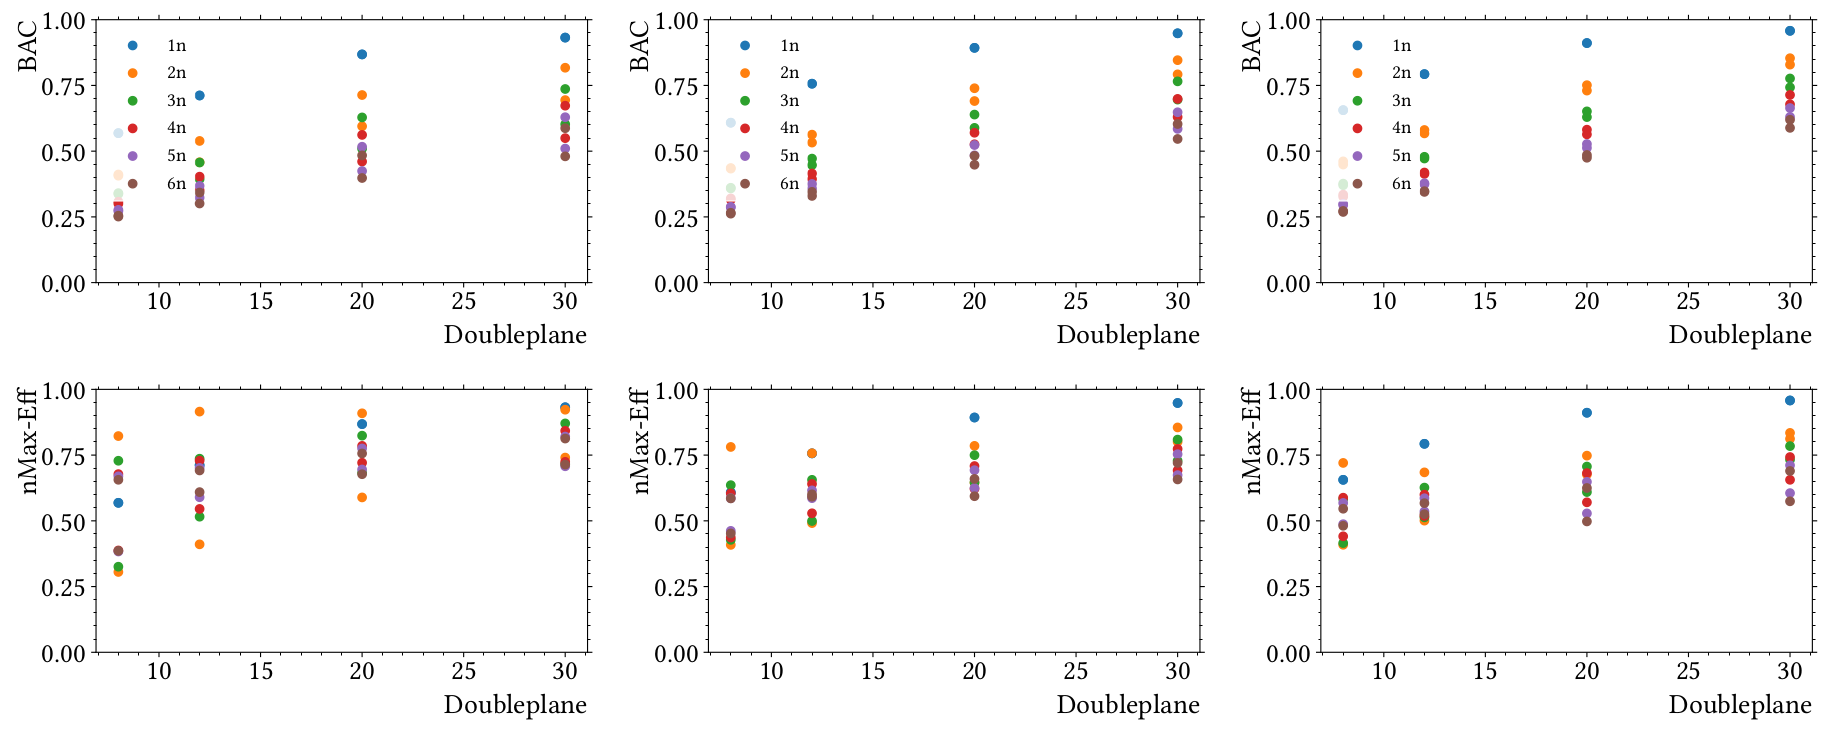

In [12]:
%matplotlib

from plotconfroot import *

fig = plt.figure(figsize=(6.224 * 3, 6.224 / 1.618 * 2))
for i, energy in enumerate(energies):
    ax = fig.add_subplot(2, 3, i + 1)
    ax.set_xlabel(r"Doubleplane", horizontalalignment="right", x=1)
    ax.set_ylim(0, 1)
    ax.set_ylabel(r"BAC", horizontalalignment="right", y=1)

    ax2 = fig.add_subplot(2, 3, 3 + i + 1)
    ax2.set_xlabel(r"Doubleplane", horizontalalignment="right", x=1)
    ax2.set_ylim(0, 1)
    ax2.set_ylabel(r"nMax-Eff", horizontalalignment="right", y=1)

    for nmax in neutrons:
        tmp = resultsdf.loc[(resultsdf["energy"] == energy) & (resultsdf["nmax"] == nmax)]
        ax.scatter(
            tmp["doubleplane"].values, tmp["bac"].values, label=f"{nmax}n",
        )
        ax2.scatter(
            tmp["doubleplane"].values, tmp["eff"].values, label=f"{nmax}n",
        )

    ax.legend(loc="upper left", prop={"size": "x-small"})
fig.savefig("results/calibr-bac-dp.pdf", bbox_inches="tight")
fig.tight_layout()
display(fig)